## Model 2:
This model is an implementation of a simple CNN 3 class image classifier.
 * It employs BatchNormalization after the first activated convolutional layer.
 * It has 3 convolutional layers
 * 3 hidden layers
 * 3 categorical outputs with Softmax activation


### Environment setup

In [14]:
# some standard packages
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os


# modelling packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam


# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix


### Data Setup

In [15]:
categories = ['hogweed', 'blueweed', 'gorse']

In [16]:
# Instantiate the ImageDataGenerator for training and validation data.
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    fill_mode='nearest',
    validation_split=0.2,
)

In [17]:
#Instantiaate the ImageDataGenerator for the test data.
# The only thing I want to do to the test data is rescaling each pixel value to be a float between 0 and 1 
# instead of an integer between 0 and 255.

test_datagen = ImageDataGenerator(rescale = 1./255)

In [18]:
# Batch size of 32 seems popular with smallish data sets.
batch_size = 32

In [19]:
# Generate the training data batches.
train_generator = train_datagen.flow_from_directory(
                                                    'data/final_BC_images/train',
                                                    target_size=(32, 32),
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    subset='training')

Found 4862 images belonging to 3 classes.


In [20]:
# Generate the validation data batches.
validation_generator = train_datagen.flow_from_directory(
                                                        'data/final_BC_images/train',
                                                        target_size=(32, 32),
                                                        color_mode='rgb',
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        shuffle=False,
                                                        subset='validation'
                                                        )

Found 1215 images belonging to 3 classes.


In [21]:
# Generate the test data batches.
# Note the number of images in the test directory should be divisible by "batch_size" 
# or the metrics functions in Results section will throw errors.
test_generator = test_datagen.flow_from_directory(
                                                  'data/final_BC_images/test',
                                                  target_size=(32, 32),
                                                  color_mode='rgb',
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 1632 images belonging to 3 classes.


In [22]:
# Saving the number of stepsizes for the training, validation and test sets 
train_stepsize = train_generator.samples//train_generator.batch_size 

valid_stepsize = validation_generator.samples//validation_generator.batch_size 

test_stepsize = test_generator.samples//test_generator.batch_size 

# Sanity check 
print(f'Training step size = {train_stepsize} \nValidation step size = {valid_stepsize} \nTest step size = {test_stepsize}')

Training step size = 151 
Validation step size = 37 
Test step size = 51


### Model Architecture
* Utillizes the simple sequential API.


In [23]:
# Building the Model
model = Sequential()

# 3 convolutional layers
model.add(Conv2D(32, (3,3), input_shape = (32,32,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3 hidden layers
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(128))
model.add(Activation('relu'))

# # The output layer with 9 neurons for 9 classes
model.add(Dense(3))
model.add(Activation('softmax'))


In [24]:
# Initiate early stop based on validation accuracy
ES = EarlyStopping(monitor='val_acc', patience=5, mode='auto', min_delta=0.0001, verbose=1)

In [25]:
# Istantiating Adam optimizer with a learning rate of 0.0001 and saving to variable 'optim'
optim = Adam(lr=0.0001)

# Compiling the CNN model 
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['acc'])

# Summary 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 128)       36992     
_________________________________________________________________
activation_8 (Activation)    (None, 13, 13, 128)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 128)        

### Model Training

In [26]:
# Fitting the model to the training data
history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_stepsize,
                                epochs=50,
                                validation_data=validation_generator,
                                validation_steps=valid_stepsize,
                                callbacks=[ES])

Epoch 1/50
151/151 [==============================] - 58s 385ms/step - loss: 0.7575 - acc: 0.6594 - val_loss: 0.9383 - val_acc: 0.7559
Epoch 2/50
151/151 [==============================] - 57s 379ms/step - loss: 0.4956 - acc: 0.8110 - val_loss: 0.6680 - val_acc: 0.7998
Epoch 3/50
151/151 [==============================] - 57s 377ms/step - loss: 0.4199 - acc: 0.8354 - val_loss: 0.4803 - val_acc: 0.8311
Epoch 4/50
151/151 [==============================] - 59s 389ms/step - loss: 0.3934 - acc: 0.8520 - val_loss: 0.3994 - val_acc: 0.8488
Epoch 5/50
151/151 [==============================] - 59s 388ms/step - loss: 0.3656 - acc: 0.8652 - val_loss: 0.3705 - val_acc: 0.8733
Epoch 6/50
151/151 [==============================] - 58s 384ms/step - loss: 0.3496 - acc: 0.8725 - val_loss: 0.3525 - val_acc: 0.8733
Epoch 7/50
151/151 [==============================] - 60s 398ms/step - loss: 0.3429 - acc: 0.8752 - val_loss: 0.3540 - val_acc: 0.8708
Epoch 8/50
151/151 [==============================] - 6

### Observation from training this model
The initial results looked promising for some epochs, but the validation loss and accuarcy were hopping around way too much. The model seems to be unstable when the learning rate was 0..001. When I run the training again with the learning rate set to 0.0001 the hopping around settled down quite a bit.

### Model Results

In [27]:
# Getting bestmodel's predictions (as probabilities) on the test set 
test_probas = model.predict_generator(test_generator, steps=test_stepsize)

# Setting the model's class prediction as the class that received the highest probability for each image
test_predictions = test_probas.argmax(axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


In [ ]:
test_probas

In [28]:
# Getting the true class labels for the test set
test_true = test_generator.classes

# Sanity check 
test_true

1632

In [29]:
test_predictions

1632

In [30]:
# Displaying the classification report for the test set
print('Classification Report\n \n', classification_report(test_true, test_predictions, target_names=categories))

Classification Report
 
               precision    recall  f1-score   support

     hogweed       0.77      0.96      0.85       506
    blueweed       0.96      0.89      0.92       523
       gorse       0.98      0.84      0.91       603

    accuracy                           0.89      1632
   macro avg       0.91      0.90      0.89      1632
weighted avg       0.91      0.89      0.90      1632



Precision and recall are quite high for both blueweed and gorse, but hogweed has a substantially lower precision than expected or desired. Based on the Confusion matrix below, it appears that some blueweed and gorse images are being classified as hogweed. I have a suspicion these are some of the images which contain clusters of plants instead of a single specimen.
I'll want to consider that further and investigate.

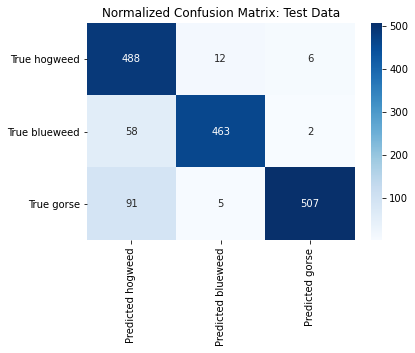

In [31]:
# Get a confusion matrix 
test_matrix = pd.DataFrame(confusion_matrix(test_true, test_predictions), 
                           columns=['Predicted ' + cat_name for cat_name in categories], 
                           index=['True ' + cat_name for cat_name in categories])

# Plotting as a heatmap 
plt.figure()
sns.heatmap(test_matrix, cmap='Blues', annot=True, fmt='g')
plt.title('Normalized Confusion Matrix: Test Data')
plt.show()

In [32]:
test_probas

array([[9.7578704e-01, 4.7428221e-03, 1.9470172e-02],
       [9.2859000e-01, 5.9232030e-02, 1.2177986e-02],
       [9.6747780e-01, 1.2591144e-02, 1.9930985e-02],
       ...,
       [1.3476094e-02, 2.2057923e-04, 9.8630327e-01],
       [1.6494714e-06, 4.8179345e-09, 9.9999833e-01],
       [9.5186132e-01, 1.2297129e-02, 3.5841502e-02]], dtype=float32)

In [33]:
test_predictions

array([0, 0, 0, ..., 2, 2, 0])

### Save Model to file
* Weights and Model architecture in a single HDF5 file.

In [37]:
model.save('KerasModel2.h5')

### Saving the model in two files
* Weights in an hdf5 file
* Model architecture in a json

In [34]:
# # Serialize model to json file model.json
# model_json = model.to_json()
# with open('model.json', 'w') as json_file:
#     json_file.write('model_json')
    

In [35]:
# # Serialize weights to HDF5 format model_weights.h5
# model.save_weights('model_weights.h5')
# print('Model save to file complete.')

Model save to file complete.
